In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import scikitplot as skplt
import mglearn
import warnings
warnings.filterwarnings("ignore")

KeyboardInterrupt: 

In [178]:
df = pd.read_csv('.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [179]:
assert len(df) == len(df['customerID'].unique())

In [180]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Now let's take a look what are the possible values for each feature:

In [181]:
out = str()
for i in df.columns:
    print("{}:{}\n".format(i, df[i].unique()))

customerID:['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender:['Female' 'Male']

SeniorCitizen:[0 1]

Partner:['Yes' 'No']

Dependents:['No' 'Yes']

tenure:[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

PhoneService:['No' 'Yes']

MultipleLines:['No phone service' 'No' 'Yes']

InternetService:['DSL' 'Fiber optic' 'No']

OnlineSecurity:['No' 'Yes' 'No internet service']

OnlineBackup:['Yes' 'No' 'No internet service']

DeviceProtection:['No' 'Yes' 'No internet service']

TechSupport:['No' 'Yes' 'No internet service']

StreamingTV:['No' 'Yes' 'No internet service']

StreamingMovies:['No' 'Yes' 'No internet service']

Contract:['Month-to-month' 'One year' 'Two year']

PaperlessBilling:['Yes' 'No']

PaymentMethod:['Electronic check' 'Mailed check' 'Bank transfer (automatic)'

Also it seems like df['TotalCharges'] has few missings:

In [182]:
df = df[df['TotalCharges'] != ' '].reset_index(drop = True)

In [183]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce') # transform from string to float value
df = df.dropna().reset_index(drop = True) #let's check that there are no other missings
df.shape

(7032, 21)

We don't need Customer ids due to they convey no information for us and they are all unique for each row of dataframe

In [184]:
ids = df['customerID']
del df['customerID']
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [185]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)
df = pd.get_dummies(df, drop_first = True)
df.rename(columns={s: s[:-4] for s in df.columns if 'Yes' in s}, inplace = True)
df.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner,Dependents,PhoneService,MultipleLines_No phone service,MultipleLines,...,StreamingTV,StreamingMovies_No internet service,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,1,29.85,29.85,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,2,53.85,108.15,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


In [186]:
df.shape

(7032, 31)

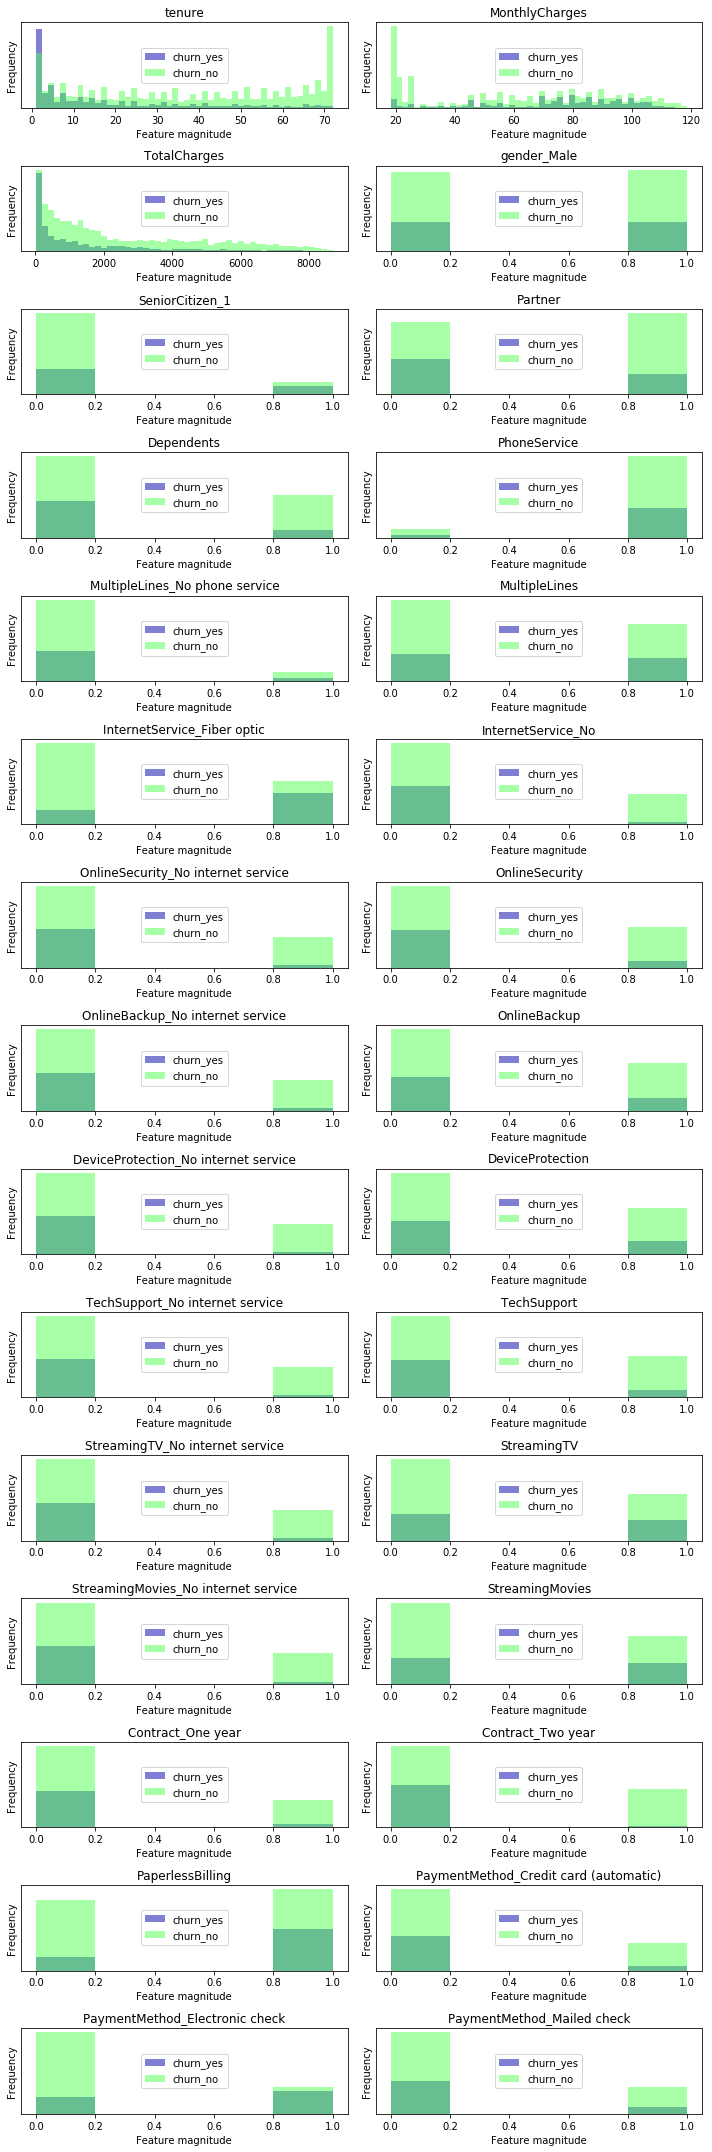

In [187]:
fig, axes = plt.subplots(15, 2, figsize=(10, 30))
churn_yes = df[df['Churn'] == 1]
churn_no = df[df['Churn'] == 0]

ax = axes.ravel()
for i in range(30):
    if i < 3:
        _, bins = np.histogram(df.values[:, i], bins=50)
    else:
        _, bins = np.histogram(df.values[:, i], bins=5)
    ax[i].hist(churn_yes.values[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(churn_no.values[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(df.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["churn_yes", "churn_no"], loc="center")
    fig.tight_layout()

# Building an optimal model

In [188]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1])

In [189]:
model = LogisticRegression()

Grid-Search with AUC
Best parameters: {'C': 1, 'penalty': 'l1'}
Best cross-validation score (AUC): 0.849
Test set AUC: 0.840


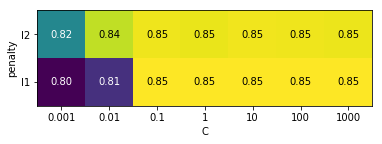

In [190]:
param_grid = {'penalty': ['l1', 'l2'], 
             'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
cv = ShuffleSplit(train_size=0.8, test_size=0.2, n_splits=10)
grid_search = GridSearchCV(model, param_grid=param_grid, cv = cv, scoring='roc_auc')
grid_search.fit(X_train, y_train)
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(7, 2).T
mglearn.tools.heatmap(scores, xlabel='C', xticklabels=param_grid['C'],
                      ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis")
print("Grid-Search with AUC")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid_search.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, grid_search.decision_function(X_test))))

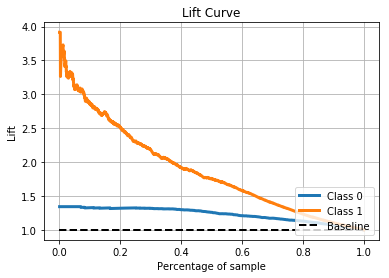

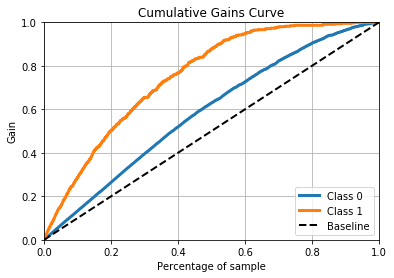

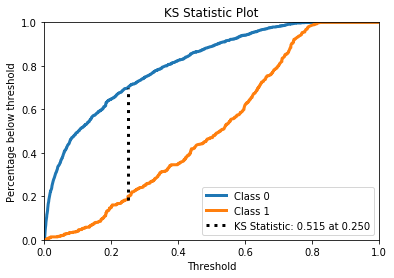

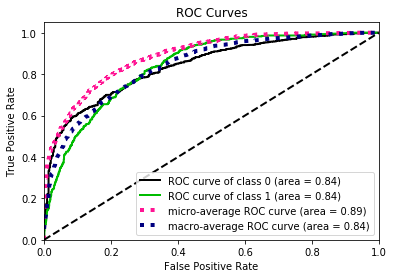

In [191]:
model = LogisticRegression(C=1, penalty = 'l1')
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test.values, pred)
skplt.metrics.plot_cumulative_gain(y_test.values, pred)
skplt.metrics.plot_ks_statistic(y_test.values, pred)
skplt.metrics.plot_roc_curve(y_test.values, pred)

# Using bootstrap for building CI of predictions

In [192]:
def bootstrap(df, n):
    auc_score = np.zeros(n)
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1])
        model = LogisticRegression(C=1, penalty = 'l1')
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_test)
        auc_score[i] = roc_auc_score(y_test, pred[:,1])
    return auc_score

In [70]:
score = bootstrap(df, 1000)

In [71]:
pd.Series(score).describe()

count    1000.000000
mean        0.844950
std         0.008730
min         0.814201
25%         0.839200
50%         0.844910
75%         0.850630
max         0.870761
dtype: float64

Let's calculate confidence intervals for our predictions using bootsrap:

In [226]:
its = 100

In [251]:
all_preds = []
for i in range(its):
    indices = np.random.choice(range(len(X_train)), size = len(X_train), replace=True)
    X_tr, y_tr = X_train.iloc[list(indices)], y_train[list(indices)]
    model = LogisticRegression(C = 1, penalty = 'l1')
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)
    all_preds.append(pred[:,1])

In [260]:
CIs = pd.DataFrame({'prediction': np.array(all_preds).mean(axis = 1), 'upper': np.percentile(all_preds, 95, axis = 1), 'lower': np.percentile(all_preds, 5, axis = 1) })
CIs.head()

,lower,prediction,upper
0,0.004899,0.262870,0.718324
1,0.005089,0.262946,0.718549
2,0.004921,0.262838,0.718405
3,0.004891,0.262872,0.718058
4,0.004897,0.262779,0.718397


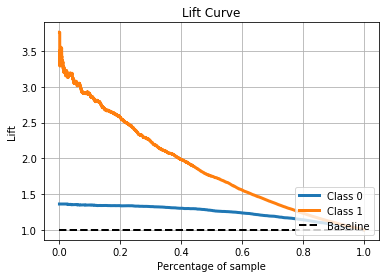

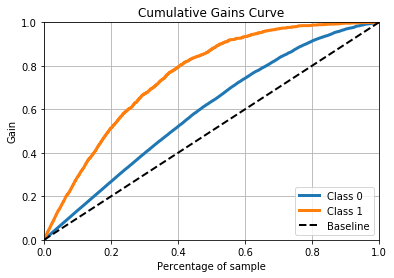

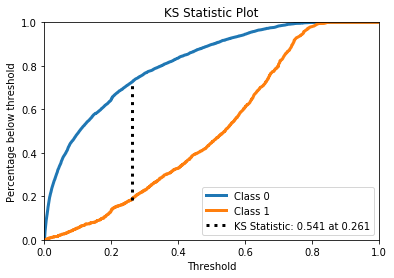

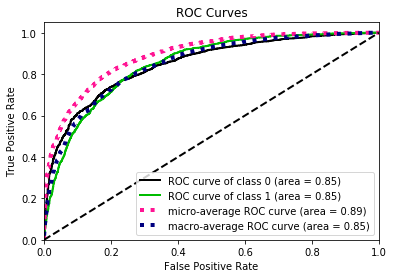

In [193]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
model = LogisticRegression(C=1, penalty = 'l1')
model.fit(X, y)
pred = model.predict_proba(X)
skplt.metrics.plot_lift_curve(y.values, pred)
skplt.metrics.plot_cumulative_gain(y.values, pred)
skplt.metrics.plot_ks_statistic(y.values, pred)
skplt.metrics.plot_roc_curve(y.values, pred)

In [194]:
def break_even(pred, plot_start = 0, plot_end = None):
    prob = np.sort(pred[:,1])[::-1]
    revenues = 25 * 0.25 * prob
    cum_revenues = np.array([sum(revenues[:i+1]) for i in range(len(revenues))])
    cost = np.array([5 * (i+1) for i in range(len(revenues))])
    if plot_end == None:
        plot_end = len(revenues)
    plt.plot([i for i in range(plot_start, plot_end)], cost[plot_start:plot_end])
    plt.plot([i for i in range(plot_start, plot_end)], cum_revenues[plot_start:plot_end])
    for i in range(len(cum_revenues)):
        if cum_revenues[i] - cost[i] <= 0:
            print('Target size: {0}'.format(i))
            return i

In [195]:
def max_profit(pred, plot_start = 0, plot_end = None):
    prob = np.sort(pred[:,1])[::-1]
    revenues = 25 * 0.25 * prob
    cum_revenues = np.array([sum(revenues[:i+1]) for i in range(len(revenues))])
    cost = np.array([5 * (i+1) for i in range(len(revenues))])
    profit = cum_revenues - cost
    if plot_end == None:
        plot_end = len(revenues)
    plt.plot([i for i in range(plot_start, plot_end)], profit[plot_start:plot_end])
    return np.where(profit == max(profit))[0][0], np.where(profit < 0)[0][0]

(41, 95)

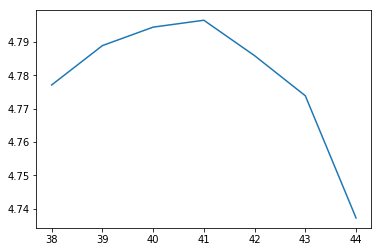

In [196]:
max_profit(pred, 38, 45)

Target size: 95


95

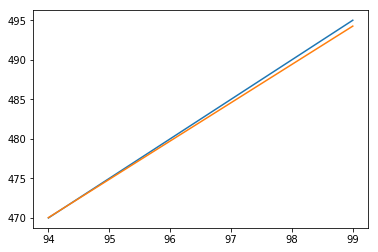

In [197]:
break_even(pred, 94, 100)

## PCA not working

In [198]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [199]:
X_s = StandardScaler().fit_transform(df.iloc[:,:-2])
pca = PCA(n_components = 8)
df_pca = pd.DataFrame(pca.fit_transform(X_s), columns = ['PC {0}'.format(i + 1) for i in range(8)])
sum(pca.explained_variance_ratio_)

0.7564733993677281

In [202]:
df_pca['Churn'] = df['Churn']
df_pca = df_pca.dropna()
print(df_pca.shape)
df_pca.head()

(7032, 9)


,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,Churn
0,-0.372014,-3.157848,3.657953,1.759262,-1.148777,0.004657,0.564430,1.254610,0
1,-0.463514,-0.664647,1.013166,-2.169642,1.105510,1.374047,-0.922125,-1.186176,0
2,-0.422622,-1.967795,0.627931,-1.860384,0.489157,-0.687690,-0.129029,-0.894629,1
3,-0.853164,-0.842119,5.057692,-0.114901,1.424097,1.587580,-0.975545,-1.110490,0
4,-0.546742,-3.216996,-1.108402,-0.399118,-0.309075,-0.621656,-0.387416,0.930595,1


In [203]:
model = LogisticRegression()

In [204]:
X_pca = df_pca.iloc[:,:-1]
X_pca.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
0,-0.372014,-3.157848,3.657953,1.759262,-1.148777,0.004657,0.564430,1.254610
1,-0.463514,-0.664647,1.013166,-2.169642,1.105510,1.374047,-0.922125,-1.186176
2,-0.422622,-1.967795,0.627931,-1.860384,0.489157,-0.687690,-0.129029,-0.894629
3,-0.853164,-0.842119,5.057692,-0.114901,1.424097,1.587580,-0.975545,-1.110490
4,-0.546742,-3.216996,-1.108402,-0.399118,-0.309075,-0.621656,-0.387416,0.930595


In [205]:
y_pca = df_pca['Churn']
y_pca.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: uint8

In [206]:
model.fit(X_pca.values, y_pca.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [207]:
pred = model.predict_proba(X_pca)
pred

array([[0.49145088, 0.50854912],
       [0.88067383, 0.11932617],
       [0.69189507, 0.30810493],
       ...,
       [0.65200528, 0.34799472],
       [0.30562365, 0.69437635],
       [0.93702045, 0.06297955]])

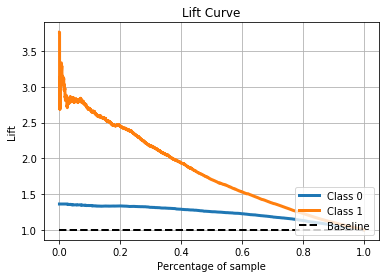

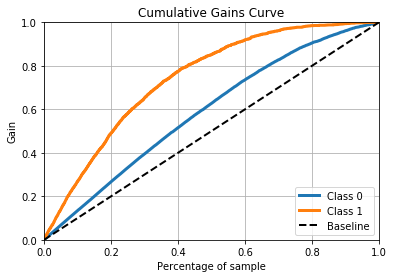

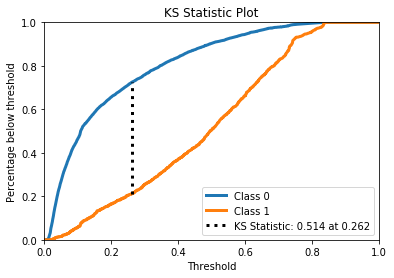

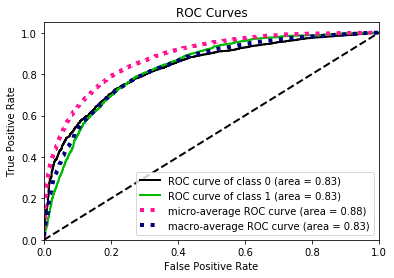

In [208]:
skplt.metrics.plot_lift_curve(y_pca, pred)
skplt.metrics.plot_cumulative_gain(y_pca, pred)
skplt.metrics.plot_ks_statistic(y_pca, pred)
skplt.metrics.plot_roc_curve(y_pca, pred)

In [209]:
X_s = StandardScaler().fit_transform(df.iloc[:,:3])
pca = PCA(n_components = 1)
df_pca = pd.DataFrame(pca.fit_transform(X_s), columns = ['PC {0}'.format(i + 1) for i in range(1)])
sum(pca.explained_variance_ratio_)

0.7265992668717507

In [210]:
df_pca = pd.merge(df_pca, df, left_index=True, right_index=True)
df_pca.head()

,PC 1,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner,Dependents,PhoneService,MultipleLines_No phone service,...,StreamingTV,StreamingMovies_No internet service,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,-1.951657,1,29.85,29.85,0,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,-0.205793,34,56.95,1889.50,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,-1.518083,2,53.85,108.15,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
3,-0.202412,45,42.30,1840.75,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,-1.233269,2,70.70,151.65,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1


In [211]:
df_pca = df_pca.dropna()
model = LogisticRegression()
X_pca = df_pca.iloc[:,:-1]
X_pca.head()

,PC 1,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner,Dependents,PhoneService,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV,StreamingMovies_No internet service,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.951657,1,29.85,29.85,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,-0.205793,34,56.95,1889.50,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,-1.518083,2,53.85,108.15,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,-0.202412,45,42.30,1840.75,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,-1.233269,2,70.70,151.65,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [212]:
y_pca = df_pca['Churn']
y_pca.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: uint8

In [213]:
model.fit(X_pca.values, y_pca.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [214]:
pred = model.predict_proba(X_pca)
pred

array([[0.36265543, 0.63734457],
       [0.94965244, 0.05034756],
       [0.69666027, 0.30333973],
       ...,
       [0.59072593, 0.40927407],
       [0.28396083, 0.71603917],
       [0.93555924, 0.06444076]])

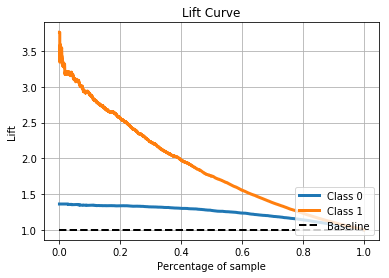

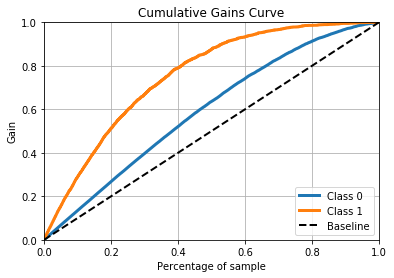

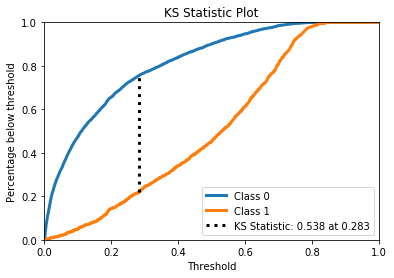

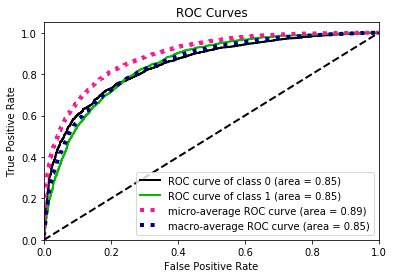

In [215]:
skplt.metrics.plot_lift_curve(y_pca, pred)
skplt.metrics.plot_cumulative_gain(y_pca, pred)
skplt.metrics.plot_ks_statistic(y_pca, pred)
skplt.metrics.plot_roc_curve(y_pca, pred)

#let's try the same with 2 components

In [217]:
pca = PCA(n_components = 2)
df_pca = pd.DataFrame(pca.fit_transform(X_s), columns = ['PC {0}'.format(i + 1) for i in range(2)])
sum(pca.explained_variance_ratio_)

0.9801863344320083

In [218]:
df_pca = pd.merge(df_pca, df, left_index=True, right_index=True)
df_pca.head()

,PC 1,PC 2,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner,Dependents,PhoneService,...,StreamingTV,StreamingMovies_No internet service,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,-1.951657,0.082753,1,29.85,29.85,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,-0.205793,0.235142,34,56.95,1889.50,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,-1.518083,-0.522542,2,53.85,108.15,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
3,-0.202412,0.891730,45,42.30,1840.75,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,-1.233269,-0.965181,2,70.70,151.65,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,1


In [219]:
df_pca = df_pca.dropna()
model = LogisticRegression()
X_pca = df_pca.iloc[:,:-1]
X_pca.head()

,PC 1,PC 2,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner,Dependents,PhoneService,...,StreamingTV_No internet service,StreamingTV,StreamingMovies_No internet service,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.951657,0.082753,1,29.85,29.85,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,-0.205793,0.235142,34,56.95,1889.50,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,-1.518083,-0.522542,2,53.85,108.15,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,-0.202412,0.891730,45,42.30,1840.75,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,-1.233269,-0.965181,2,70.70,151.65,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [220]:
y_pca = df_pca['Churn']
y_pca.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: uint8

In [221]:
model.fit(X_pca.values, y_pca.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [222]:
pred = model.predict_proba(X_pca)
pred

array([[0.36127886, 0.63872114],
       [0.94998954, 0.05001046],
       [0.69801317, 0.30198683],
       ...,
       [0.59073562, 0.40926438],
       [0.28056175, 0.71943825],
       [0.9358015 , 0.0641985 ]])

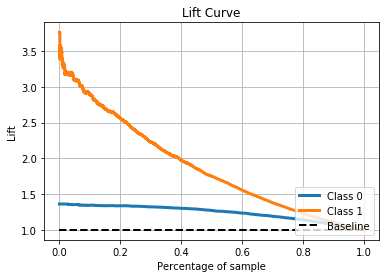

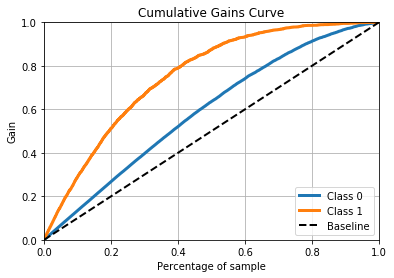

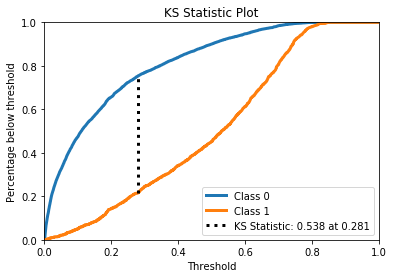

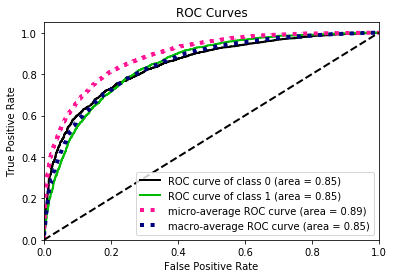

In [223]:
skplt.metrics.plot_lift_curve(y_pca, pred)
skplt.metrics.plot_cumulative_gain(y_pca, pred)
skplt.metrics.plot_ks_statistic(y_pca, pred)
skplt.metrics.plot_roc_curve(y_pca, pred)